In [39]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("talk")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**


# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots

In [40]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'interpolationODs.xlsx') #this is data from SMG interpolation approach
intensityBG_path=os.path.join(data_folder,'2020-03-31-12-07-21-COVID_March31_fluanalysis4.xlsx')

In [41]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)
serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True)
serum_day_df.fillna(0, inplace=True)
serum_day_df.columns=['serum', 'day']
serum_day_df['day'] = serum_day_df['day'].astype(int)
plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
plate_info_df.drop(['Sera ID'], axis=1, inplace=True)

print(plate_info_df[plate_info_df['serum']=='006']['day'].unique())
plate_info_df

[7]


,well_id,type,dilution,serum,day
0,A1,Control,1.000000e+00,HumanReferencePlasma,0
1,A2,Control,1.000000e+00,anti-HA mAb MEDI8852,0
2,A3,Control,1.000000e+00,antii-HA mAb TF19,0
3,A4,Diagnostic,1.000000e-03,MS,0
4,A5,Diagnostic,1.000000e-03,MS,7
...,...,...,...,...,...
91,H8,Diagnostic,6.100000e-08,005-18,0
92,H9,Diagnostic,6.100000e-08,005-18,7
93,H10,Diagnostic,6.100000e-08,005-18,18
94,H11,Diagnostic,6.100000e-08,006,7


In [42]:
converter = {col: str for col in range(0,7)}
antigen_df = pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter, index_col=0)
antigen_df = antigen_df.unstack().reset_index(name='antigen') # unpivot (linearize) the table
antigen_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,NaN
1,0,1,NaN
2,0,2,NaN
3,0,3,NaN
4,0,4,NaN
5,0,5,NaN
6,1,0,Flu vaccine 2018-2019
7,1,1,H1 HA
8,1,2,H3 HA
9,1,3,H7 HA


# Read ODs of all wells

## Read data

In [43]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [44]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(antigenOD_path, sheet_name=well_key, index_col=0)
        OD_1_well_df = OD_1_well_df.unstack().reset_index(name='OD') # unpivot (linearize) the table
        OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
        OD_1_well_df['well_id'] = well_key
        wellID[r,c] = well_key
        OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

,antigen_row,antigen_col,OD,well_id
0,0,0,0.125924,A1
1,0,1,0.065551,A1
2,0,2,0.108782,A1
3,0,3,0.049754,A1
4,0,4,0.014399,A1
...,...,...,...,...
3451,5,1,-0.000895,H12
3452,5,2,0.004881,H12
3453,5,3,0.004917,H12
3454,5,4,0.006237,H12


# Merge tables into one

In [45]:
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='left', on=['well_id'])



In [46]:
# Check well A2
OD_df[OD_df['well_id']=='A2']


,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
36,0,0,0.243091,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
37,0,1,0.177513,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
38,0,2,0.104507,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
39,0,3,0.087800,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
40,0,4,0.074499,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
41,0,5,0.154753,A2,NaN,Control,1.0,anti-HA mAb MEDI8852,0
42,1,0,0.012528,A2,Flu vaccine 2018-2019,Control,1.0,anti-HA mAb MEDI8852,0
43,1,1,0.000342,A2,H1 HA,Control,1.0,anti-HA mAb MEDI8852,0
44,1,2,-0.001378,A2,H3 HA,Control,1.0,anti-HA mAb MEDI8852,0
45,1,3,-0.002662,A2,H7 HA,Control,1.0,anti-HA mAb MEDI8852,0


# Read analysis output from Scienion 

In [114]:
# Read all wells into dictionary. 
intensityBG_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(intensityBG_path, sheet_name=well_key)
        OD_1_well_df['well_id'] = well_key
        wellID[r,c] = well_key
        intensityBG_df = intensityBG_df.append(OD_1_well_df, ignore_index=True)

intensityBG_df
intensityBG_df.shape

(2880, 20)

In [115]:
# parse spot ids
spot_id_df=intensityBG_df['ID'].str.extract(r'spot-(\d)-(\d)')
spot_id_df = spot_id_df.astype(int) - 1 # index starting from 0
spot_id_df.rename(columns={0: 'antigen_row', 1: 'antigen_col'}, inplace=True)

intensityBG_df = pd.concat([spot_id_df, intensityBG_df], axis=1)
intensityBG_df.drop('ID', axis=1, inplace=True)
intensityBG_df

,antigen_row,antigen_col,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],Saturation,...,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,0,1,2755.0,3956.0,Positive,59.466,NaN,233.0,42589.0,0.0,...,148.720,34.616,108.953,248.292,95.626,89.254,16.976,82.577,151.794,A1
1,0,2,3153.0,3931.0,Positive,112.558,NaN,143.0,16012.0,0.0,...,199.917,33.804,126.249,246.914,94.326,87.358,12.888,81.791,128.467,A1
2,0,3,3556.0,3934.0,Positive,112.848,NaN,145.0,16539.0,0.0,...,198.406,32.477,124.199,238.888,91.708,85.558,11.255,81.544,126.790,A1
3,0,4,3962.0,3935.0,Positive,109.533,NaN,147.0,16995.0,0.0,...,194.254,35.239,120.929,247.629,85.104,84.721,2.240,80.616,94.365,A1
4,1,1,2748.0,4272.0,Positive,81.453,NaN,208.0,34141.0,0.0,...,168.885,34.582,117.669,237.894,95.478,87.432,18.151,82.174,155.544,A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,4,5,4823.0,5534.0,Borderline,9.046,NaN,141.0,15554.0,0.0,...,85.148,3.176,77.757,91.862,76.442,76.102,2.686,70.035,91.705,H12
2876,5,1,3159.0,5952.0,Negative,0.250,NaN,200.0,31382.0,0.0,...,76.483,1.947,71.286,86.964,76.234,76.232,1.610,71.035,81.466,H12
2877,5,2,3564.0,5952.0,Negative,0.000,NaN,200.0,31382.0,0.0,...,75.400,1.593,70.677,79.472,75.603,75.608,1.613,71.072,80.711,H12
2878,5,3,3802.0,6081.0,Negative,2.964,NaN,101.0,7980.0,0.0,...,78.159,4.434,72.645,96.834,75.267,75.195,1.727,70.114,81.216,H12


In [85]:
# invert the intensity and compute ODs, check A2
df_scn = intensityBG_df[['antigen_row',	'antigen_col', 'well_id', 'Median', 'Background Median']]
df_scn['OD'] = np.log10((255 - intensityBG_df['Background Median']) /(255 - intensityBG_df['Median']))
df_scn[df_scn['well_id']=='A2']

<ipython-input-85-460322705f39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scn['OD'] = np.log10((255 - intensityBG_df['Background Median']) /(255 - intensityBG_df['Median']))


,antigen_row,antigen_col,well_id,Median,Background Median,OD
30,0,1,A2,205.572,80.824,0.547015
31,0,2,A2,196.424,80.208,0.474802
32,0,3,A2,196.564,79.690,0.477126
33,0,4,A2,204.342,78.795,0.541370
34,1,1,A2,79.503,79.456,0.000116
35,1,2,A2,78.450,78.337,0.000278
36,1,3,A2,78.484,78.068,0.001022
37,1,4,A2,77.370,77.501,-0.000320
38,2,0,A2,216.368,80.325,0.655284
39,2,1,A2,78.065,78.223,-0.000388


# Read Canary pipeline median intensities and background

In [56]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
canaryIntensity_path=os.path.join(data_folder,'intensities.xlsx') #this is intensity data from SMG interpolation approach
canaryBackground_path=os.path.join(data_folder,'backgrounds.xlsx')

In [50]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
canaryIntensity=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
intensityWellID=np.empty((8,12),dtype=object)

In [53]:
# Read all intensity wells into dictionary and into a 4D numpy array.
canaryIntensity_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(canaryIntensity_path, sheet_name=well_key, index_col=0)
        OD_1_well_df = OD_1_well_df.unstack().reset_index(name='Canary Intensity') # unpivot (linearize) the table
        OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
        OD_1_well_df['well_id'] = well_key
        intensityWellID[r,c] = well_key
        canaryIntensity_df = canaryIntensity_df.append(OD_1_well_df, ignore_index=True)
canaryIntensity_df

,antigen_row,antigen_col,Canary Intensity,well_id
0,0,0,0.486819,A1
1,0,1,0.559181,A1
2,0,2,0.506709,A1
3,0,3,0.581870,A1
4,0,4,0.633642,A1
...,...,...,...,...
3451,5,1,0.698039,H12
3452,5,2,0.691067,H12
3453,5,3,0.693299,H12
3454,5,4,0.693575,H12


In [54]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
canaryBackground=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
backgroundWellID=np.empty((8,12),dtype=object)

In [57]:
# Read all background wells into dictionary and into a 4D numpy array.
canaryBackground_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(canaryBackground_path, sheet_name=well_key, index_col=0)
        OD_1_well_df = OD_1_well_df.unstack().reset_index(name='Canary Background') # unpivot (linearize) the table
        OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
        OD_1_well_df['well_id'] = well_key
        backgroundWellID[r,c] = well_key
        canaryBackground_df = canaryBackground_df.append(OD_1_well_df, ignore_index=True)
canaryBackground_df

,antigen_row,antigen_col,Canary Background,well_id
0,0,0,0.650565,A1
1,0,1,0.650285,A1
2,0,2,0.650939,A1
3,0,3,0.652499,A1
4,0,4,0.655003,A1
...,...,...,...,...
3451,5,1,0.696602,H12
3452,5,2,0.698878,H12
3453,5,3,0.701193,H12
3454,5,4,0.703607,H12


In [120]:
canaryBackgroundTRIMMED_df=pd.DataFrame()
canaryBackgroundTRIMMED_df=canaryBackground_df.drop(['antigen_row','antigen_col','well_id'], axis=1)

,Canary Background
0,0.650565
1,0.650285
2,0.650939
3,0.652499
4,0.655003
...,...
3451,0.696602
3452,0.698878
3453,0.701193
3454,0.703607


In [121]:
# Concatenate the intensity and background dataframes corresponding to the canary pipeline output
canaryIBG_df = pd.concat([canaryIntensity_df,canaryBackgroundTRIMMED_df], axis=1)
canaryIBG_df

,antigen_row,antigen_col,Canary Intensity,well_id,Canary Background
0,0,0,0.486819,A1,0.650565
1,0,1,0.559181,A1,0.650285
2,0,2,0.506709,A1,0.650939
3,0,3,0.581870,A1,0.652499
4,0,4,0.633642,A1,0.655003
...,...,...,...,...,...
3451,5,1,0.698039,H12,0.696602
3452,5,2,0.691067,H12,0.698878
3453,5,3,0.693299,H12,0.701193
3454,5,4,0.693575,H12,0.703607


In [122]:
# Make a new column that is the Canary background-intensity

canary_BGsubtI = canaryIBG_df["Canary Background"]-canaryIBG_df["Canary Intensity"]
canary_BGsubtI_df = pd.DataFrame(canary_BGsubtI, columns = ['BG-I'])
canary_BGsubtI_df



,BG-I
0,0.163746
1,0.091104
2,0.144230
3,0.070629
4,0.021361
...,...
3451,-0.001437
3452,0.007811
3453,0.007894
3454,0.010033


In [123]:
# Merge the Canary background-Intensity dataframe with the existing Canary data dataframe
canaryIBG_df = pd.concat([canaryIBG_df,
                 canary_BGsubtI_df], axis=1)
canaryIBG_df


,antigen_row,antigen_col,Canary Intensity,well_id,Canary Background,BG-I
0,0,0,0.486819,A1,0.650565,0.163746
1,0,1,0.559181,A1,0.650285,0.091104
2,0,2,0.506709,A1,0.650939,0.144230
3,0,3,0.581870,A1,0.652499,0.070629
4,0,4,0.633642,A1,0.655003,0.021361
...,...,...,...,...,...,...
3451,5,1,0.698039,H12,0.696602,-0.001437
3452,5,2,0.691067,H12,0.698878,0.007811
3453,5,3,0.693299,H12,0.701193,0.007894
3454,5,4,0.693575,H12,0.703607,0.010033


In [124]:
canaryIBG_df = pd.merge(canaryIBG_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
canaryIBG_df = pd.merge(canaryIBG_df,
                 plate_info_df,
                 how='left', on=['well_id'])
canaryIBG_df

,antigen_row,antigen_col,Canary Intensity,well_id,Canary Background,BG-I,antigen,type,dilution,serum,day
0,0,0,0.486819,A1,0.650565,0.163746,NaN,Control,1.0,HumanReferencePlasma,0
1,0,1,0.559181,A1,0.650285,0.091104,NaN,Control,1.0,HumanReferencePlasma,0
2,0,2,0.506709,A1,0.650939,0.144230,NaN,Control,1.0,HumanReferencePlasma,0
3,0,3,0.581870,A1,0.652499,0.070629,NaN,Control,1.0,HumanReferencePlasma,0
4,0,4,0.633642,A1,0.655003,0.021361,NaN,Control,1.0,HumanReferencePlasma,0
...,...,...,...,...,...,...,...,...,...,...,...
3451,5,1,0.698039,H12,0.696602,-0.001437,NaN,Control,1.0,AssayDiluentControl,0
3452,5,2,0.691067,H12,0.698878,0.007811,NaN,Control,1.0,AssayDiluentControl,0
3453,5,3,0.693299,H12,0.701193,0.007894,NaN,Control,1.0,AssayDiluentControl,0
3454,5,4,0.693575,H12,0.703607,0.010033,NaN,Control,1.0,AssayDiluentControl,0


# Make a dataframe that joins the Canary and the Scienion data

In [94]:
intensityBG_AU_df=pd.DataFrame()
intensityBG_AU_df = intensityBG_df[['antigen_row','antigen_col', 'well_id', 'Median', 'Background Median', 'Intensity (median, background corrected) [AU]']]
intensityBG_AU_df


,antigen_row,antigen_col,well_id,Median,Background Median,"Intensity (median, background corrected) [AU]"
0,0,1,A1,148.720,89.254,59.466
1,0,2,A1,199.917,87.358,112.558
2,0,3,A1,198.406,85.558,112.848
3,0,4,A1,194.254,84.721,109.533
4,1,1,A1,168.885,87.432,81.453
...,...,...,...,...,...,...
2875,4,5,H12,85.148,76.102,9.046
2876,5,1,H12,76.483,76.232,0.250
2877,5,2,H12,75.400,75.608,0.000
2878,5,3,H12,78.159,75.195,2.964


[None]

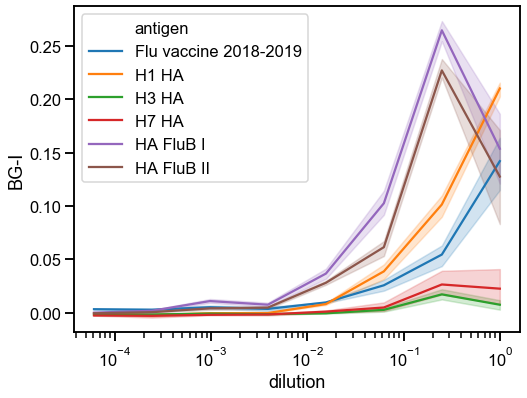

In [125]:
serum = 'HumanReferencePlasma'
sub_df = canaryIBG_df[(canaryIBG_df['serum']==serum)] 
sub_df2 = intensityBG_AU_df[(intensityBG_AU_df['serum']==serum)]
# ref_plm_df = ref_plm_df.dropna()
plt.figure(figsize =(8, 6))
ax = sns.lineplot(x="dilution", y="BG-I", hue='antigen', data=sub_df)
ax.set(xscale="log")
ax2 = ax1.twinx() 
ax2 = sns.lineplot(x="dilution",y="Intensity (median, background corrected) [AU]", hue='antigen', data=sub_df2)

# Plot standard curves

## Plot antibody response to all antigens from one serum sample

[None]

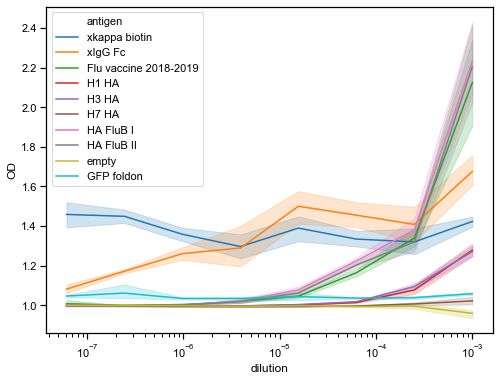

In [172]:
serum = 'HumanReferencePlasma'
sub_df = OD_df[(OD_df['serum']==serum)] 
# ref_plm_df = ref_plm_df.dropna()
plt.figure(figsize =(8, 6))
ax = sns.lineplot(x="dilution", y="OD", hue='antigen', data=sub_df)
ax.set(xscale="log")

## Compare across sera at Day 0

<Figure size 576x432 with 0 Axes>

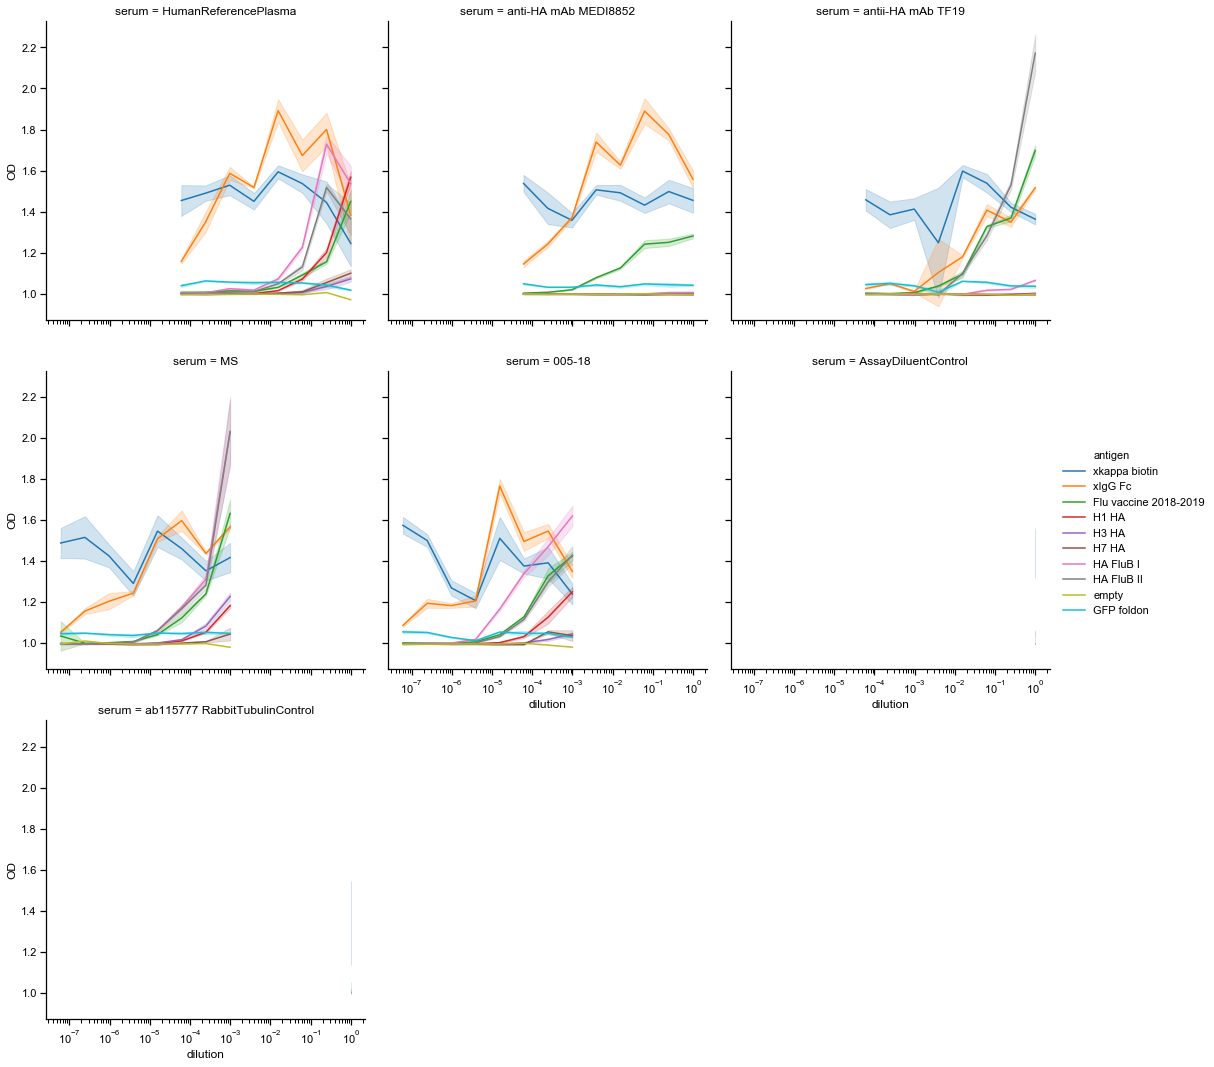

In [229]:
day = 0
sub_df = OD_df[(OD_df['day']==day)] 
plt.figure(figsize =(8, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="antigen", col="serum", 
                data=sub_df, col_wrap=3, kind='line', estimator=np.mean, ci='sd')
ax.set(xscale="log")

## Compare sera for each antigen

In [236]:
import scipy.optimize as optimization
import itertools

def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)
   
def plot_n_fit(xdata, ydata, **kwargs):
    sns.regplot(xdata, ydata, fit_reg=False,               
             x_estimator=np.mean)
    guess = [0, 1, 1e-4, 1]
    params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess, bounds=(0, np.inf))#, maxfev=1)
    x_input = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), 20)
    plt.plot(x_input, fourPL(x_input, *params), label='Fitted function')

def fit2df(df, model):
    sera = df['serum'].unique()
    antigens = df['antigen'].unique()
    keys = itertools.product(sera, antigens)
    df_fit = pd.DataFrame(columns=df.columns)
    for serum, antigen in keys:
        sub_df = df[(df['serum']==serum) & (df['antigen']==antigen)]
        days = sub_df['day'].unique()
        for day in days:
            df_day_fit = pd.DataFrame(columns=df.columns)
            day_df = sub_df[(sub_df['day']==day)]
            guess = [0, 1, 1e-4, 1]
            xdata = day_df['dilution'].to_numpy()
            ydata = day_df['OD'].to_numpy()
            params, params_covariance = optimization.curve_fit(model, xdata, ydata, guess, bounds=(0, np.inf), maxfev=1e4)
            x_input = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), 20)
            y_fit = fourPL(x_input, *params)
            
            df_day_fit['dilution'] = x_input
            df_day_fit['OD'] = y_fit
            df_day_fit['serum'] = ' '.join([serum, 'fit'])
            df_day_fit['antigen'] = antigen
            df_day_fit['type'] = day_df['type'].unique()[0]
            df_day_fit['day'] = day
            df_fit = df_fit.append(df_day_fit)  
    return df_fit
OD_df_fit = fit2df(OD_df, fourPL)

HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
MS
MS
MS
MS
MS
MS
MS
MS
MS
MS
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
006
006
006
006
006
006
006
006
006
006
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
ab115777 RabbitTubulinControl
ab115777 RabbitTubulinControl


In [237]:
OD_df_fit

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
0,NaN,NaN,1.453866,NaN,xkappa biotin,Control,0.000061,HumanReferencePlasma fit,0
1,NaN,NaN,1.469282,NaN,xkappa biotin,Control,0.000102,HumanReferencePlasma fit,0
2,NaN,NaN,1.469503,NaN,xkappa biotin,Control,0.000169,HumanReferencePlasma fit,0
3,NaN,NaN,1.469506,NaN,xkappa biotin,Control,0.000282,HumanReferencePlasma fit,0
4,NaN,NaN,1.469506,NaN,xkappa biotin,Control,0.000471,HumanReferencePlasma fit,0
...,...,...,...,...,...,...,...,...,...
15,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
16,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
17,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
18,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0


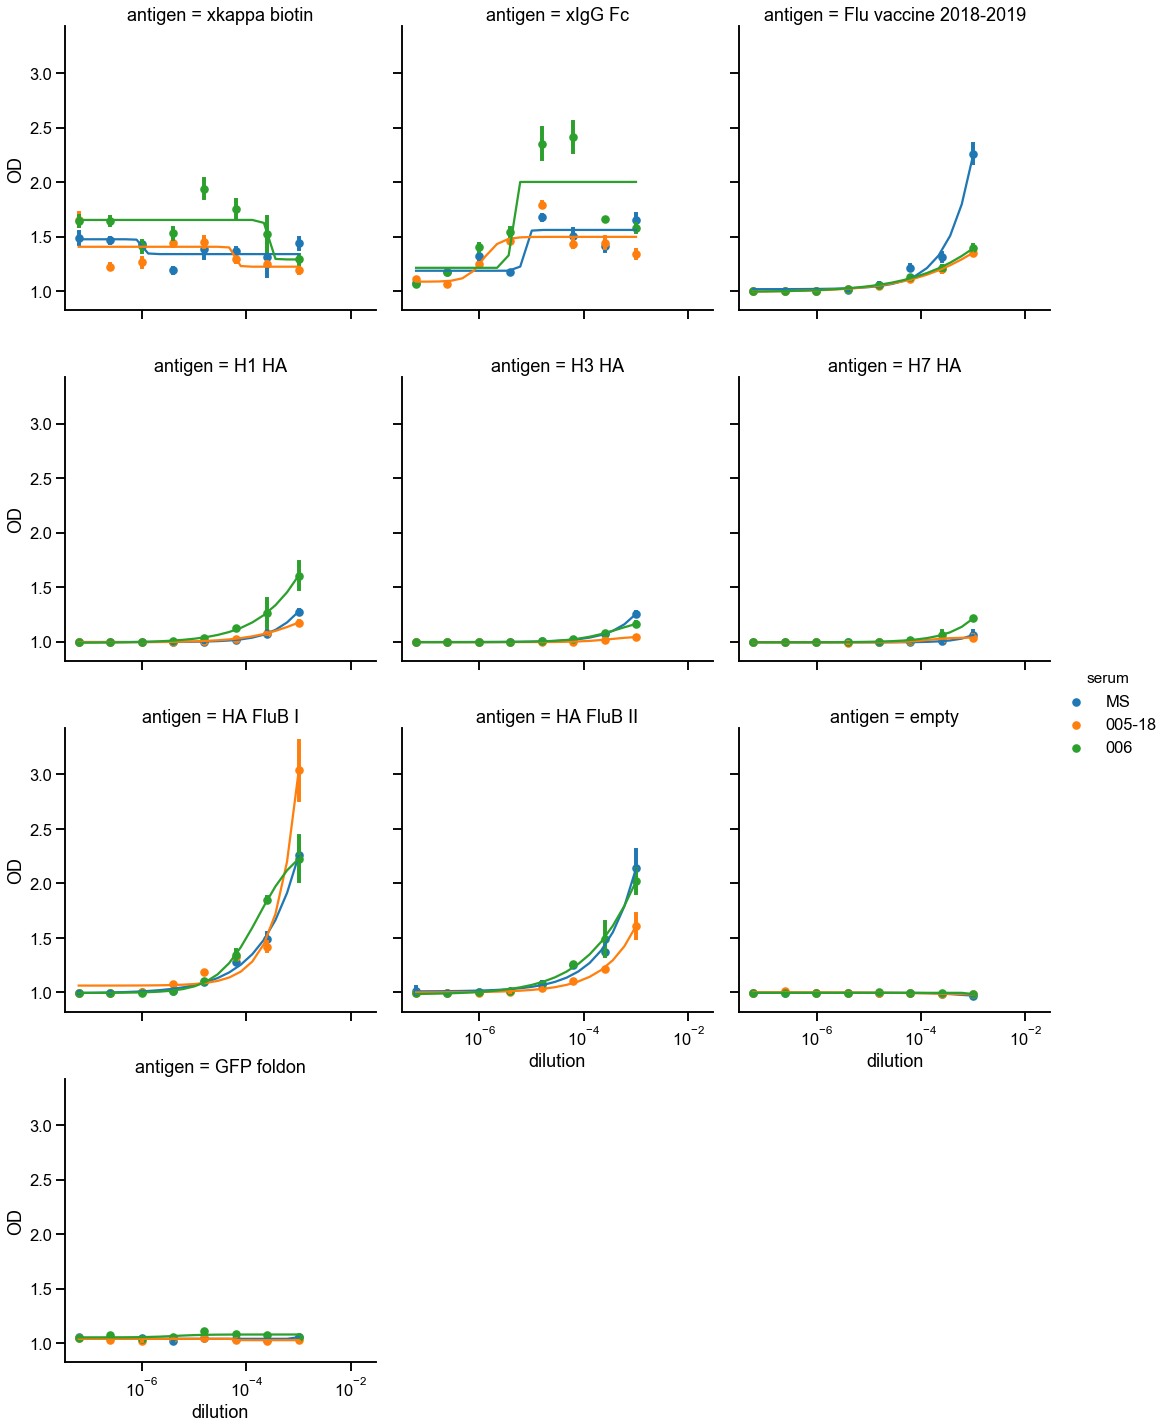

In [246]:
day = 7
serum_type = 'Diagnostic'
sub_df = OD_df[(OD_df['day']==day) & (OD_df['type']==serum_type)]

g = sns.lmplot(x="dilution", y="OD",
                hue="serum", col="antigen", ci='sd',
                 data=sub_df, col_wrap=3, fit_reg=False, x_estimator=np.mean)
ax.set(xscale="log")
sub_OD_df_fit=OD_df_fit[(OD_df_fit['day']==day) & (OD_df_fit['type']==serum_type)]

for antigen, ax in zip(sub_df['antigen'].unique(), g.axes.flat):
    df_fit = sub_OD_df_fit[sub_OD_df_fit['antigen']==antigen]
    sns.lineplot(x="dilution", y="OD", hue='serum', data=df_fit, ax=ax, legend=False)
    ax.set(xscale="log")

In [11]:
serum = 'AssayDiluentControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

serum = 'ab115777 RabbitTubulinControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

[1.]
[1.]


# Read identity of wells and antigen spots in 2D arrays if preferred

In [12]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

array([['A1', 'HumanReferencePlasma', 'Control', 1.0],
       ['A2', 'anti-HA mAb MEDI8852', 'Control', 1.0],
       ['A3', 'antii-HA mAb TF19', 'Control', 1.0],
       ['A4', 'MS-Day0', 'Diagnostic', 0.001],
       ['A5', 'MS-Day7', 'Diagnostic', 0.001],
       ['A6', 'MS-Day14', 'Diagnostic', 0.001],
       ['A7', 'MS-Day21', 'Diagnostic', 0.001],
       ['A8', '005-18-Day0', 'Diagnostic', 0.001],
       ['A9', '005-18-Day7', 'Diagnostic', 0.001],
       ['A10', '005-18-Day18', 'Diagnostic', 0.001],
       ['A11', '006-Day7', 'Diagnostic', 0.001],
       ['A12', 'AssayDiluentControl', 'Control', 1.0],
       ['B1', 'HumanReferencePlasma', 'Control', 0.25],
       ['B2', 'anti-HA mAb MEDI8852', 'Control', 0.25],
       ['B3', 'antii-HA mAb TF19', 'Control', 0.25],
       ['B4', 'MS-Day0', 'Diagnostic', 0.00025],
       ['B5', 'MS-Day7', 'Diagnostic', 0.00025],
       ['B6', 'MS-Day14', 'Diagnostic', 0.00025],
       ['B7', 'MS-Day21', 'Diagnostic', 0.00025],
       ['B8', '005-18-Day0

In [13]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([['xkappa biotin', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'xkappa biotin'],
       ['xkappa biotin', 'H1 HA', 'H1 HA', 'H1 HA', 'H1 HA', 'empty'],
       ['xIgG Fc', 'H3 HA', 'H3 HA', 'H3 HA', 'H3 HA', 'GFP foldon'],
       ['xIgG Fc', 'H7 HA', 'H7 HA', 'H7 HA', 'H7 HA', 'GFP foldon'],
       ['xIgG Fc', 'HA FluB I', 'HA FluB I', 'HA FluB I', 'HA FluB I',
        'GFP foldon'],
       ['xkappa biotin', 'HA FluB II', 'HA FluB II', 'HA FluB II',
        'HA FluB II', 'xkappa biotin']], dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [14]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [15]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [16]:
pprint(antigenOD[0,0]) # Well A1

array([[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
        1.3063261 ],
       [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
        0.97001301],
       [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
        1.01487095],
       [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
        1.01577171],
       [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
        1.01984698],
       [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
        1.13418449]])


In [17]:
pprint(antigenOD[0,3]) # well A4

array([[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
        1.32212619],
       [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
        0.9799163 ],
       [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
        1.04502998],
       [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
        1.05024331],
       [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
        1.04949529],
       [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
        1.40289936]])


#### logical indexing

In [18]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
         1.32212619],
        [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
         0.9799163 ],
        [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
         1.04502998],
        [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
         1.05024331],
        [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
         1.04949529],
        [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
         1.40289936]]])


In [19]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
         1.3063261 ],
        [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
         0.97001301],
        [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
         1.01487095],
        [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
         1.01577171],
        [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
         1.01984698],
        [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
         1.13418449]]])


# Plot standard curve.

In [20]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
#pprint(wellIdx)
#pprint(antigenIdx)

## Find concentrations in control wells

#The control wells in this plate are in columns. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [21]:
controlWells = []
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    controlWells.append(wellsinthisrow)
pprint(controlWells)

[['A2', 'A3'],
 ['B2', 'B3'],
 ['C2', 'C3'],
 ['D2', 'D3'],
 ['E2', 'E3'],
 ['F2', 'F3'],
 ['G2', 'G3'],
 ['H2', 'H3']]


In [24]:
controlWells = np.reshape(controlWells,(16,))
controlConcentrations=np.concatenate([plateInfo[wellIdx == well, wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.1e-05, 6.1e-05],
      dtype=object)


In [25]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10000e-05])


In [26]:
controlWellsMEDI=controlWells[0::2]
pprint(controlWellsMEDI)

array(['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], dtype='<U2')


## Let's look at mAb MEDI8852 against spot 'Flu vaccine 2018-2019' in the control wells.

In [27]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])
pprint(antigenvaccine)

array([[1.29361701, 1.28230958, 1.26620668, 1.28148715],
       [1.22413749, 1.25108522, 1.26219094, 1.26221479],
       [1.23226354, 1.21985598, 1.24805682, 1.26364718],
       [1.1328589 , 1.12572158, 1.11748446, 1.12382501],
       [1.07654113, 1.07959817, 1.08066351, 1.07320915],
       [1.01554702, 1.02020619, 1.01955793, 1.01968565],
       [1.00726404, 1.00590698, 1.00645212, 1.00599513],
       [1.00224073, 1.00265987, 1.00239297, 1.00151115]])


In [28]:
#antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])

#plt.figure(figsize=(10,10))
#plt.plot(concentrations,antigenvaccine,concentrations,np.mean(antigenvaccine,axis=1),lw=4 );
#plt.legend(['spot-1-2','spot-1-3','spot-1-4','spot-1-5','mean'])
#plt.title('anti-HA mAb MEDI8852 to Flu vaccine 2018-2019');


## Fit a 4PL to mean values from anti-HA mAB MEDI8852 to vaccine spots

#To generate a curve, arrange a np array of standard curve concentrations in ascending order, and arrays of ODs from standard curve and unknown samples in increasing concentration (i.e. highest dilution at first element of array)

In [29]:
concentrations2=[300,
75,
18.75,
4.6875,
1.171875,
0.29296875,
0.073242188,
0.018310547]
concentrations2=np.flip(concentrations2)
pprint(concentrations2)

array([1.8310547e-02, 7.3242188e-02, 2.9296875e-01, 1.1718750e+00,
       4.6875000e+00, 1.8750000e+01, 7.5000000e+01, 3.0000000e+02])


In [30]:
flippedmeans=np.flip(np.mean(antigenvaccine,axis=1)) #flip the mean values to be in increasing order

#In the following cell, input xdata as array of concentrations and ydata as array of ODs for standard curve. Adjust labels and title on plot. 

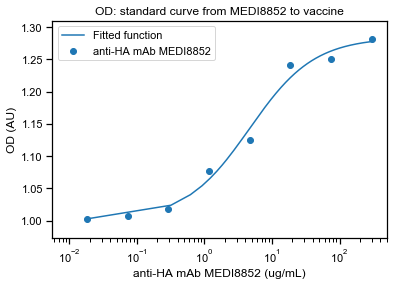

In [51]:
import scipy.optimize as optimization
xdata = concentrations2
ydata = flippedmeans
def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)

guess = [0, 0.5, 0.5, 1]
params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess, bounds=(0, np.inf))#, maxfev=1)

x_min, x_max = np.amin(xdata), np.amax(xdata)
xs = np.linspace(x_min, x_max, 1000)
ax = plt.scatter(xdata, ydata, label='anti-HA mAb MEDI8852')
plt.plot(xs, fourPL(xs, *params), label='Fitted function')
plt.xscale("log")
plt.legend(loc='best')
plt.xlabel('anti-HA mAb MEDI8852 (ug/mL)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from MEDI8852 to vaccine');
plt.show()

#The concentration of MEDI8852 starts at 300 ug/mL (or 10x), so we can add that to the plot for interpolation

In [44]:
pprint(params) #These are the parameters for the 4PL

array([1.00088831, 0.90685777, 4.62797342, 1.28376892])


In [33]:
def getConcentration(ODs,params):
    A=[params[0]]
    A=np.asarray(A)
    B=[params[1]]
    B=np.asarray(B)
    C=[params[2]]
    C=np.asarray(C)
    D=[params[3]]
    D=np.asarray(D)
# I think there is an issue with raising negative numbers to a fractional exponent. This needs to be fixed
    #return C*((((A-D)/(ODs-D))-1) **(1/B))
    return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))

In [34]:
test60=np.array([1,0.99,1.632,1.24])
test61=getConcentration(test60,params)
pprint(test61)

array([        nan,         nan,         nan, 30.10002861])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


In [135]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIMSDay0,axis=1)

allMeans=[mFluVaccineMSDay0,mH1HAMSDay0, mH3HAMSDay0,mH7HAMSDay0,mHAFluBIMSDay0,mHAFluBIIMSDay0]

allMeans = np.asarray(allMeans)

allConcentrations=getConcentration(allMeans,params)
pprint(allMeans)
pprint(allConcentrations)

array([[1.6325937 , 1.24057201, 1.12274793, 1.04168365, 1.00825405,
        1.0023307 , 0.99973903, 1.03495   ],
       [1.18284141, 1.05365641, 1.01095905, 0.99956109, 0.99464464,
        0.99662646, 0.99682175, 0.99788761],
       [1.22759098, 1.08346679, 1.01743137, 1.00075848, 0.99729104,
        0.99765584, 0.99699758, 0.99808423],
       [1.04459296, 1.00691867, 1.00022285, 0.99342826, 0.99325535,
        0.99510629, 0.9959808 , 0.99560323],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447]])
array([[           nan, 3.06204191e+01, 3.40359700e+00, 6.49534761e-01,
        8.52921127e-02, 1.37992645e-02,            nan, 5.16502649e-01],
       [8.86398656e+00, 9.12289699e-01, 1.21739347e-01,            nan,
                   nan,            nan,            nan,            nan],
       [2.15532111e+01, 1.74199

<ipython-input-133-ca68501019d1>:12: RuntimeWarning: invalid value encountered in power
  return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))


## Multiply by dilution factor to get the corrected concentration values

In [114]:
initialConcentration=allConcentrations[:,0] #All antigens at the initial concentration for Day 0 from MS serum
correctedConcentration=initialConcentration*1000 #in ug/mL
pprint(correctedConcentration) #in ug/mL


array([           nan,  8863.98656432, 21553.21107321,   710.20283383,
                  nan,            nan])


In [115]:
correctedConcentrationResult = {'Flu vaccine 2018-2019':[correctedConcentration[0]],'H1 HA':[correctedConcentration[1]], 'H3 HA':[correctedConcentration[2]],'H7 HA':[correctedConcentration[3]] ,'HA FluB I':[correctedConcentration[4]], 'HA FluB II':[correctedConcentration[5]]}
pprint(correctedConcentrationResult)
#df = pd.DataFrame(data=correctedConcentrationResult)

{'Flu vaccine 2018-2019': [nan],
 'H1 HA': [8863.986564317329],
 'H3 HA': [21553.211073212395],
 'H7 HA': [710.2028338295794],
 'HA FluB I': [nan],
 'HA FluB II': [nan]}
